## Libraries

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2

## Load files

In [14]:
root_dir = r"C:\Users\User\Desktop\mv\archive"

train_images_dir = os.path.join(root_dir,
    "Human Bone Fractures Multi-modal Image Dataset (HBFMID)",
    "Bone Fractures Detection",
    "train",
    "images"
)

train_labels_dir = os.path.join(root_dir,
    "Human Bone Fractures Multi-modal Image Dataset (HBFMID)",
    "Bone Fractures Detection",
    "train",
    "labels"
)

image_files = [f for f in os.listdir(train_images_dir) if f.lower().endswith('.jpg')]

data = []

# loop each image to find respective label and check the class of each fractre
for img_file in image_files:
    label_file = os.path.splitext(img_file)[0] + ".txt"
    label_path = os.path.join(train_labels_dir, label_file)
    
    classes = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                # we save class
                cls_id = int(line.strip().split()[0])  
                classes.append(cls_id)

    data.append({
        "image_name": img_file,
        "classes_present": classes
    })

df = pd.DataFrame(data)

# we only want class 9 fracture for this exercise for a proof of concept (it seemed the easiest tbh)
df_class9 = df[df['classes_present'].apply(lambda x: 9 in x)]

print(f"# images with Class 9 fracture (transverse): {len(df_class9)}")

# sanity_check
print(df_class9.head(10))


# images with Class 9 fracture (transverse): 105
                                          image_name classes_present
96    11_jpg.rf.4e0c52ff3a3d18d1ad21d5434147cabe.jpg          [5, 9]
98    11_jpg.rf.635db39c0bec39127fa448a47019aaa5.jpg          [5, 9]
100   11_jpg.rf.d0f9140b22023676b8ca9d316949b021.jpg          [5, 9]
103  120_jpg.rf.2f9badfc6a724ccbbc22667103533178.jpg          [8, 9]
107  120_jpg.rf.8a1b9bd391917ee1c46c90b11dc6c850.jpg          [8, 9]
109  120_jpg.rf.e2c059e824e9d98319558f1c214a5c3f.jpg          [8, 9]
233   13_jpg.rf.3301a0994bf342b0bac5aec93ee08ead.jpg          [9, 9]
243   13_jpg.rf.c6c5e7fd79bfda158da6343fe9385b36.jpg          [9, 9]
247   13_jpg.rf.f270ed84fca93faa062ee61389d94a4b.jpg          [9, 9]
268  141_jpg.rf.0d269faa88c4b46fa6303ef1fa3bba70.jpg             [9]


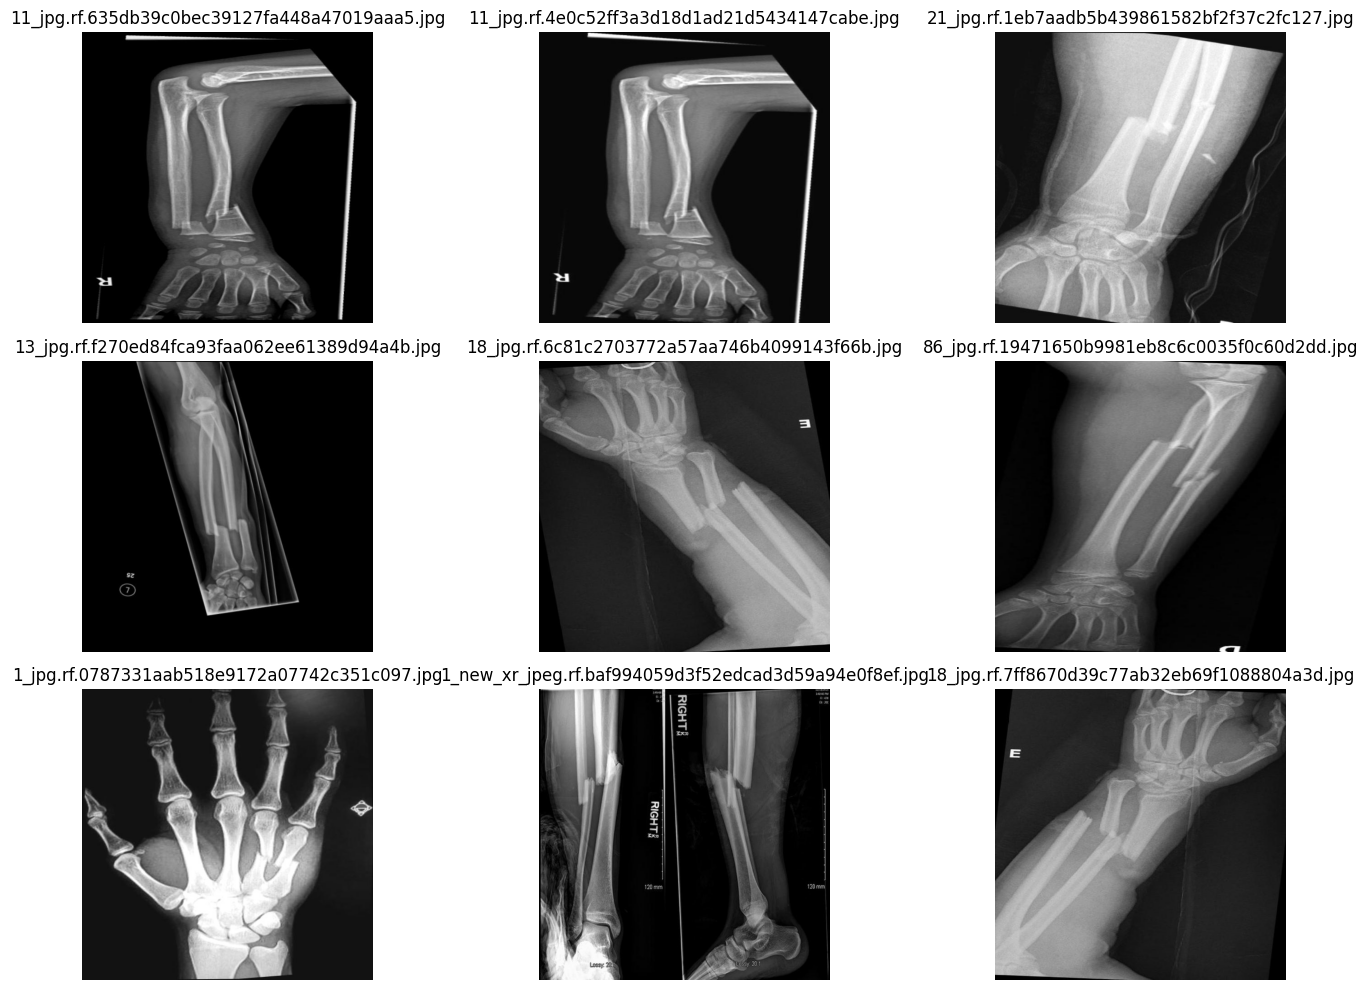

In [15]:
sample_imgs = df_class9['image_name'].sample(9, random_state=30).tolist()

plt.figure(figsize=(15,10))

for i, img_name in enumerate(sample_imgs, 1):
    img_path = os.path.join(train_images_dir, img_name)
    img = Image.open(img_path)
    plt.subplot(3,3,i)
    plt.imshow(img)
    plt.title(img_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


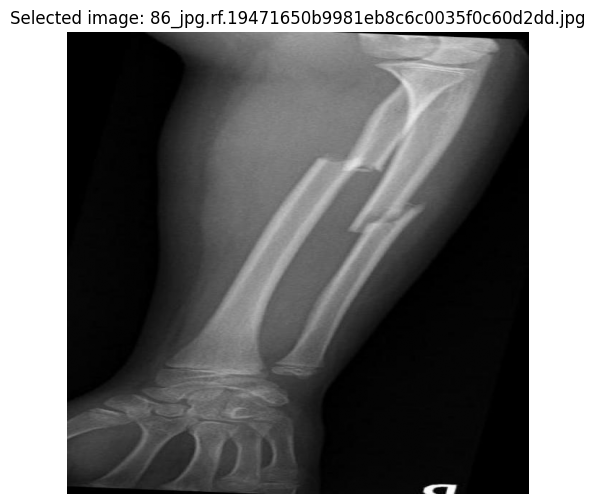

In [16]:
# we select a specific image of our liking to use as the template

selected_img_name = "86_jpg.rf.19471650b9981eb8c6c0035f0c60d2dd.jpg" 

img_path = os.path.join(train_images_dir, selected_img_name)
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.title(f"Selected image: {selected_img_name}")
plt.axis('off')
plt.show()


## Locating template

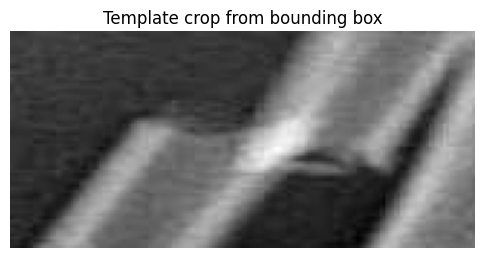

In [17]:
label_file = os.path.splitext(selected_img_name)[0] + ".txt"
label_path = os.path.join(train_labels_dir, label_file)

height, width = img.shape

# all bounding boxes for class 9 will go here
boxes_class9 = []

with open(label_path, "r") as f:
    for line in f:
        parts = line.strip().split()
        cls_id = int(parts[0]) # first number in txt file is the class
        if cls_id == 9:
            x_center, y_center, w_box, h_box = map(float, parts[1:])
            x1 = int((x_center - w_box / 2) * width)
            y1 = int((y_center - h_box / 2) * height)
            x2 = int((x_center + w_box / 2) * width)
            y2 = int((y_center + h_box / 2) * height)
            boxes_class9.append((x1, y1, x2, y2))


x1, y1, x2, y2 = boxes_class9[0]

# padding to be sure
pad = 10
x1 = max(x1 - pad, 0)
y1 = max(y1 - pad, 0)
x2 = min(x2 + pad, width)
y2 = min(y2 + pad, height)

template = img[y1:y2, x1:x2]

plt.figure(figsize=(6,6))
plt.imshow(template, cmap='gray')
plt.title("Template crop from bounding box")
plt.axis('off')
plt.show()


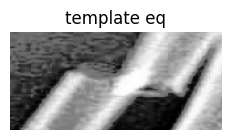

In [18]:
# increase the contrast with equalization

template = cv2.equalizeHist(template)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(template, cmap='gray')
plt.title("template eq")
plt.axis('off')
plt.show()


Max match value: 0.9783067107200623
Best match location: (304, 144)


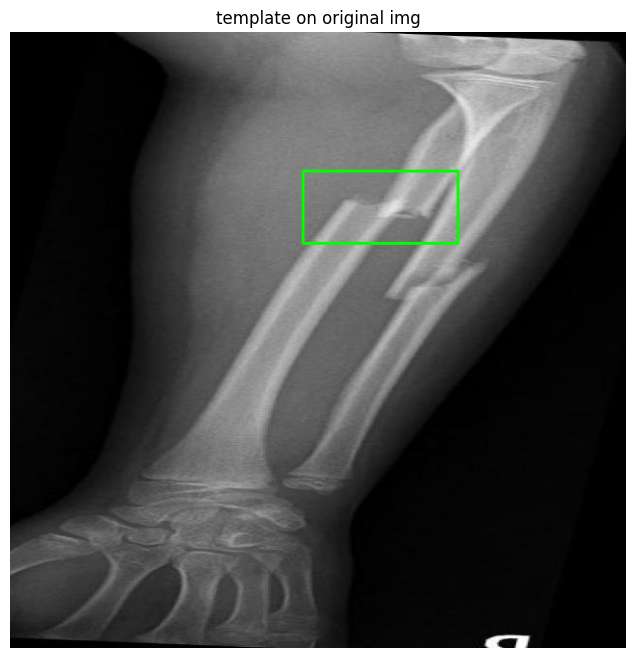

In [19]:
# Match the template to its own image for sanity check

result = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)

min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

print(f"Max match value: {max_val}")
print(f"Best match location: {max_loc}")

# draw fracture box
top_left = max_loc
h, w = template.shape
bottom_right = (top_left[0] + w, top_left[1] + h)

# do a RBG version of gray to show the green rectangle
img_rbg = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.rectangle(img_rbg, top_left, bottom_right, (0, 255, 0), 2)

plt.figure(figsize=(8,8))
plt.imshow(img_rbg)
plt.title("template on original img")
plt.axis('off')
plt.show()


## Load files (validation test)

In [20]:
# find images from class 9 (validation test)

val_images_dir = os.path.join(root_dir,
    "Human Bone Fractures Multi-modal Image Dataset (HBFMID)",
    "Bone Fractures Detection",
    "valid",
    "images"
)
val_labels_dir = os.path.join(root_dir,
    "Human Bone Fractures Multi-modal Image Dataset (HBFMID)",
    "Bone Fractures Detection",
    "valid",
    "labels"
)

val_image_files = [f for f in os.listdir(val_images_dir) if f.lower().endswith(('.jpg'))]

data = []

# loop to find matching label
for img_file in val_image_files:
    label_file = os.path.splitext(img_file)[0] + ".txt"
    label_path = os.path.join(val_labels_dir, label_file)
    
    classes = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls_id = int(line.strip().split()[0])
                classes.append(cls_id)
    
    data.append({
        "image_name": img_file,
        "classes_present": classes
    })

df_val = pd.DataFrame(data)

# forever class 9
df_val_class9 = df_val[df_val['classes_present'].apply(lambda x: 9 in x)]

print(df_val_class9.head())


                                         image_name classes_present
11   11_jpg.rf.345c6a6acdc33a82b8f35c0c67a2c97a.jpg          [5, 9]
12   11_jpg.rf.c6acf1f06cb259ac4a65f3d8c3180ad7.jpg          [5, 9]
19   13_jpg.rf.c60c3990885b00b5212b167a92dc7192.jpg          [9, 9]
20   13_jpg.rf.fbae973ff9a37f2b92fe734c9d409b85.jpg          [9, 9]
22  141_jpg.rf.2f63cf09a40fe9458aab67e5caeecf64.jpg             [9]


## Template Matching & Evaluation

Image: 11_jpg.rf.345c6a6acdc33a82b8f35c0c67a2c97a.jpg | Max match score: 0.4835 | IoU with ground truth: 0.3644


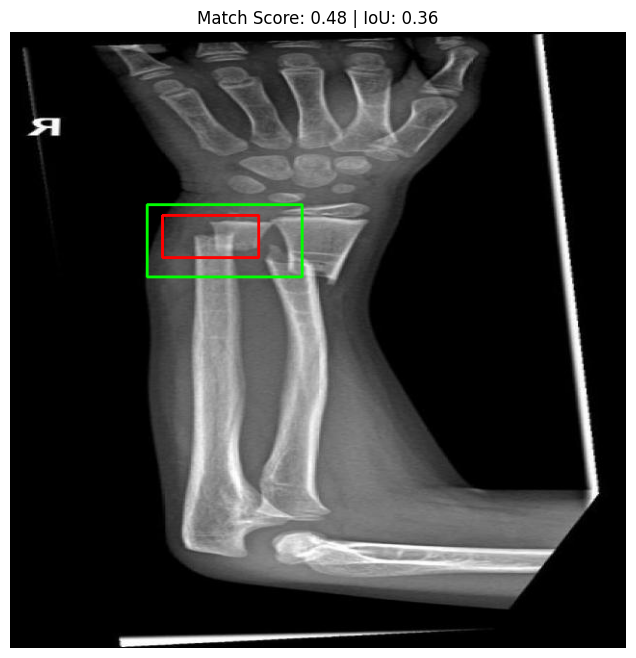

Image: 11_jpg.rf.c6acf1f06cb259ac4a65f3d8c3180ad7.jpg | Max match score: 0.4417 | IoU with ground truth: 0.0000


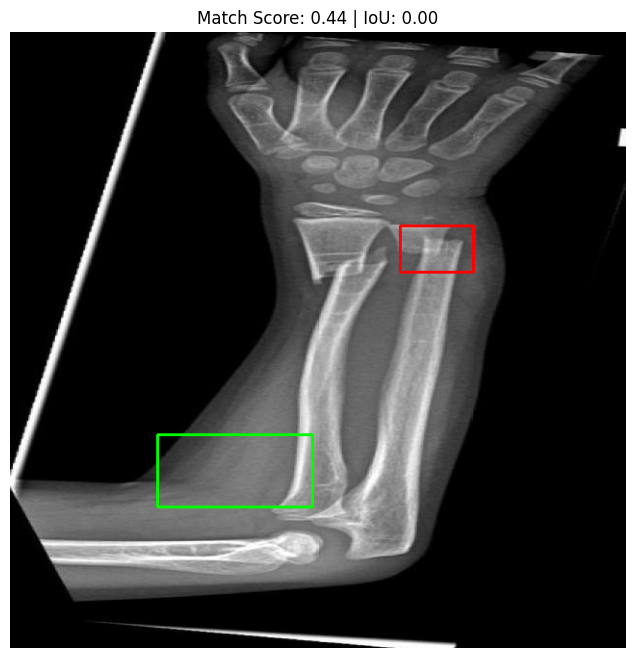

Image: 13_jpg.rf.c60c3990885b00b5212b167a92dc7192.jpg | Max match score: 0.4621 | IoU with ground truth: 0.0000


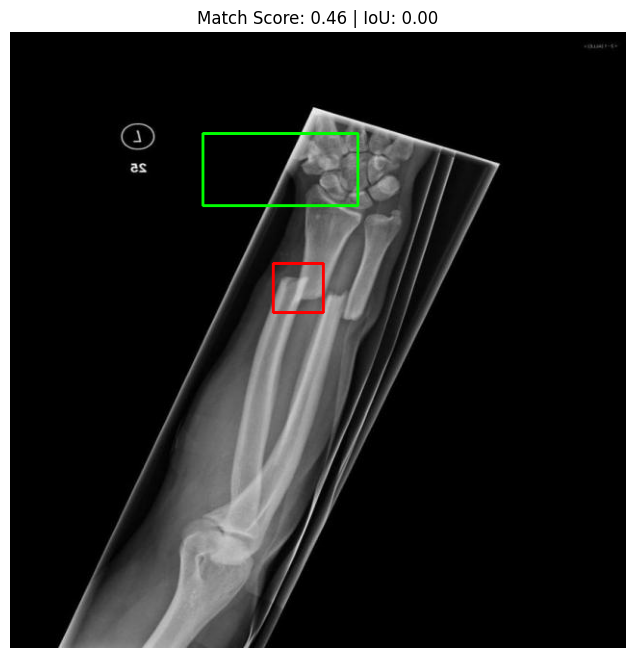

Image: 13_jpg.rf.fbae973ff9a37f2b92fe734c9d409b85.jpg | Max match score: 0.4012 | IoU with ground truth: 0.0344


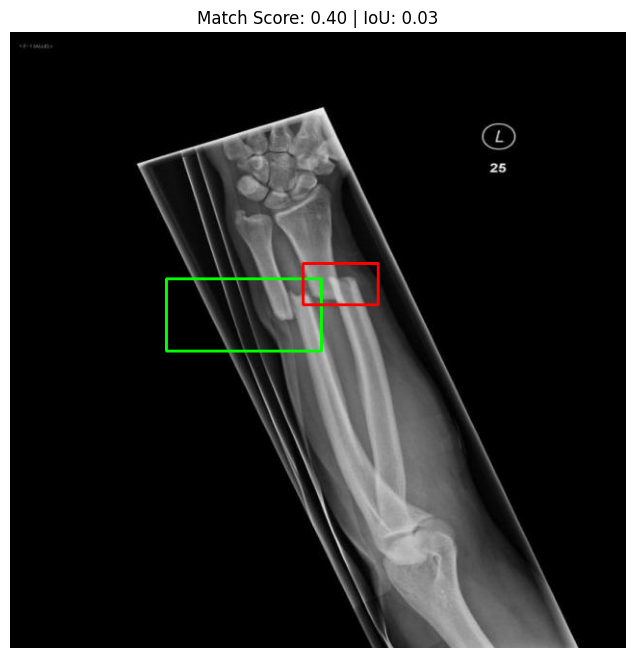

Image: 141_jpg.rf.2f63cf09a40fe9458aab67e5caeecf64.jpg | Max match score: 0.3924 | IoU with ground truth: 0.0000


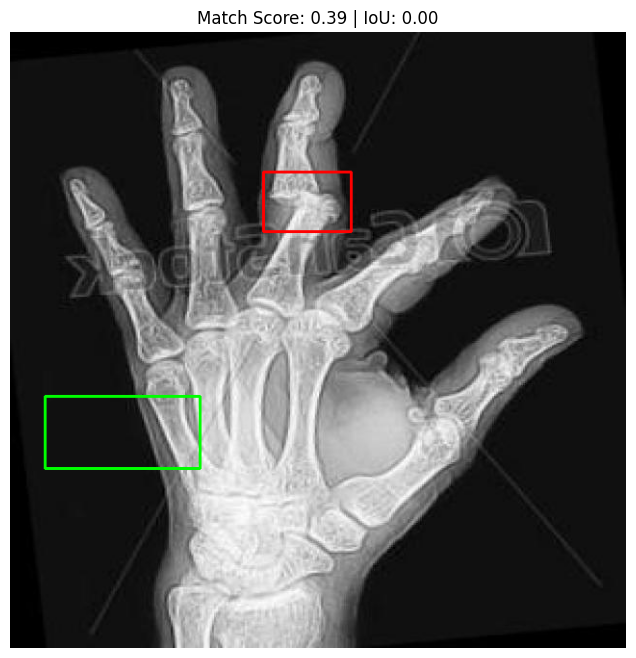

Image: 18_jpg.rf.d8c2a68bf70f182e7a9ea34fecb00af2.jpg | Max match score: 0.4953 | IoU with ground truth: 0.0000


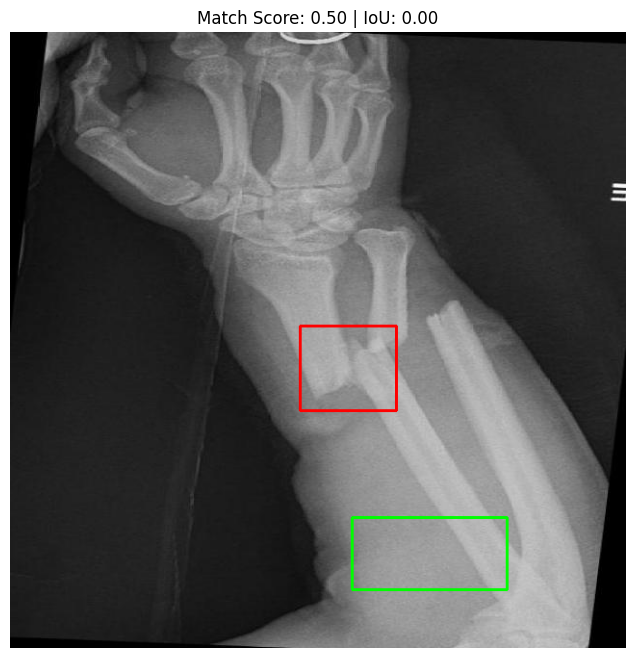

Image: 21_jpg.rf.6131d5b6de921380a2729b18d5ffae9a.jpg | Max match score: 0.4318 | IoU with ground truth: 0.0000


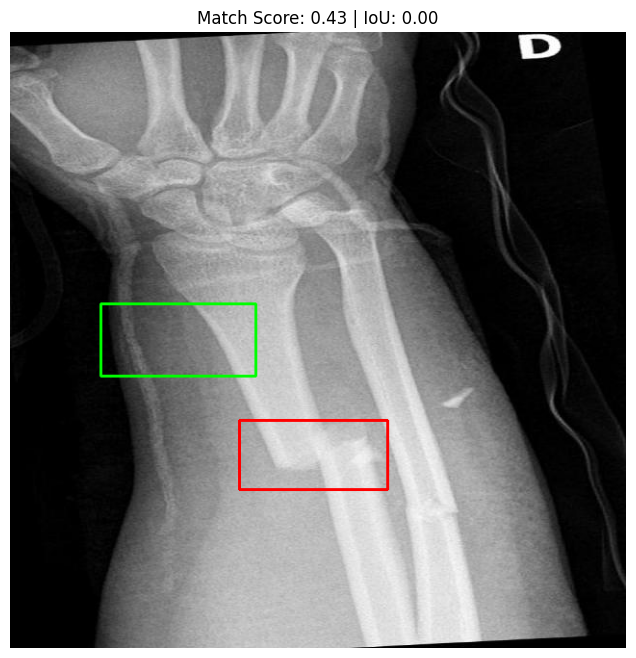

Image: 21_jpg.rf.d146a4a16cc8b656ff6a2cbb4a8e73e9.jpg | Max match score: 0.4362 | IoU with ground truth: 0.1225


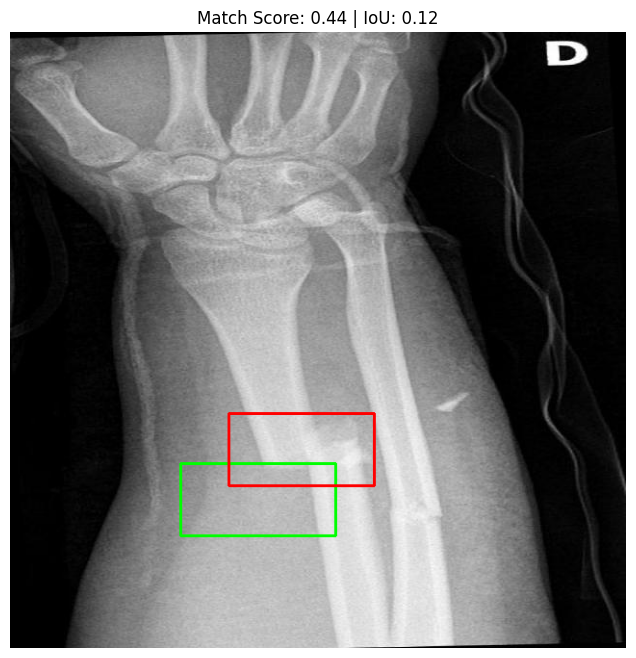

Image: 52_jpg.rf.e93bd4c049b6e79f5308ff291f36e776.jpg | Max match score: 0.5248 | IoU with ground truth: 0.4991


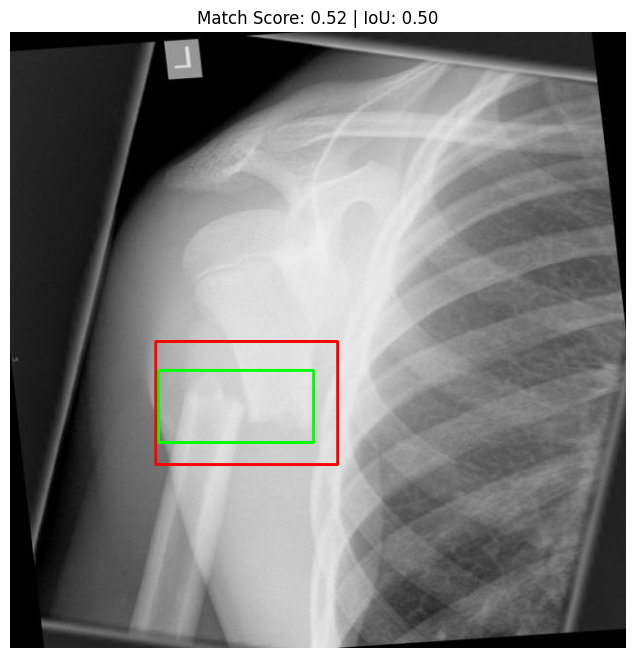

Image: 54_jpg.rf.ea3da326f16383028b4047b5483889ff.jpg | Max match score: 0.4802 | IoU with ground truth: 0.0000


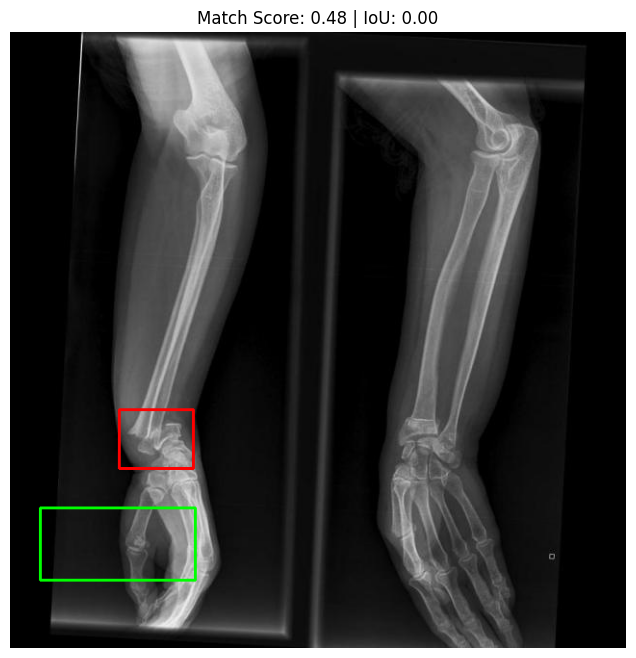

Image: 61_jpg.rf.52f46b5604f8dbf220fac62cb6bc45ca.jpg | Max match score: 0.4792 | IoU with ground truth: 0.1045


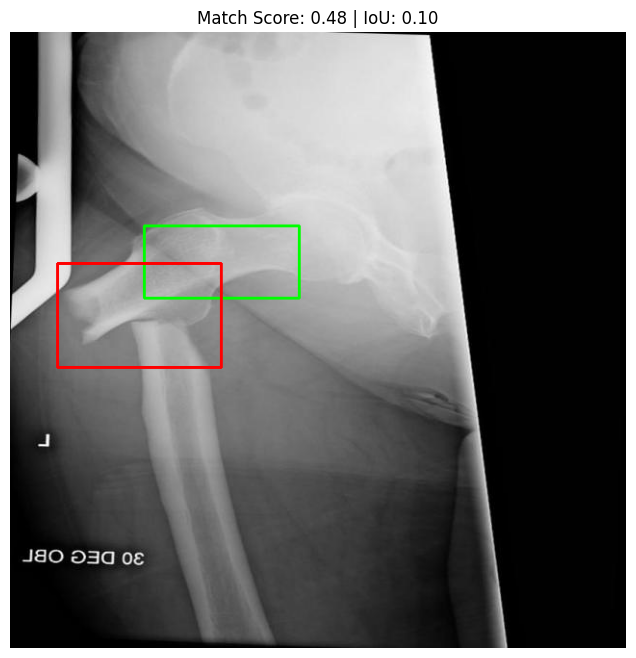

In [23]:
# iou method (Intersection of Union), overlap between template box and real box 

def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interWidth = max(0, xB - xA)
    interHeight = max(0, yB - yA)
    interArea = interWidth * interHeight

    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    iou_val = interArea / float(boxAArea + boxBArea - interArea)
    return iou_val

ious = []

for val_img_name in df_val_class9['image_name']:
    val_img_path = os.path.join(val_images_dir, val_img_name)
    val_img = cv2.imread(val_img_path, cv2.IMREAD_GRAYSCALE)
    
    # equalizatio
    val_img_eq = cv2.equalizeHist(val_img)
    
    # template matching
    result = cv2.matchTemplate(val_img_eq, template, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    
    # draw template
    top_left = max_loc
    bottom_right = (top_left[0] + template.shape[1], top_left[1] + template.shape[0])
    detected_box = (top_left[0], top_left[1], bottom_right[0], bottom_right[1])

    # draw  real (ground truth) box for class 9 from labels
    label_file = os.path.splitext(val_img_name)[0] + ".txt"
    label_path = os.path.join(val_labels_dir, label_file)

    gt_box = None
    height, width = val_img.shape

    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            cls_id = int(parts[0])
            if cls_id == 9:
                x_center, y_center, w_box, h_box = map(float, parts[1:])
                x1 = int((x_center - w_box / 2) * width)
                y1 = int((y_center - h_box / 2) * height)
                x2 = int((x_center + w_box / 2) * width)
                y2 = int((y_center + h_box / 2) * height)
                gt_box = (x1, y1, x2, y2)
                break 

    if gt_box is not None:
        iou_val = iou(detected_box, gt_box)
        ious.append(iou_val)
        print(f"Image: {val_img_name} | Max match score: {max_val:.4f} | IoU with ground truth: {iou_val:.4f}")
    else:
        print(f"Image: {val_img_name} | Max match score: {max_val:.4f} | No ground truth found")

    val_img_rbg = cv2.cvtColor(val_img, cv2.COLOR_GRAY2BGR)
    cv2.rectangle(val_img_rbg, top_left, bottom_right, (0, 255, 0), 2)  # template box green
    if gt_box is not None:
        cv2.rectangle(val_img_rbg, (gt_box[0], gt_box[1]), (gt_box[2], gt_box[3]), (0, 0, 255), 2)  # ground truth box red

    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(val_img_rbg, cv2.COLOR_BGR2RGB))
    plt.title(f"Match Score: {max_val:.2f} | IoU: {iou_val:.2f}")
    plt.axis('off')
    plt.show()
